<a href="https://colab.research.google.com/github/belhassen07/Ndevlopi/blob/master/HCP_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at ConnectomeDB. Instructions for this are on pp. 24-25 of the HCP Reference Manual.

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

For a detailed description of the tasks have a look pages 45-54 of the HCP reference manual.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 38.9 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Basic Parameters

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

## Experiment Definitions

In [5]:
# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

# Downloading data

## Downloading data file

In [6]:
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

## Extract data

In [7]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

# Helper functions

## Function: load_single_timeseries

In [8]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

## Function: load_evs

In [9]:
def load_evs(subject, experiment, run, n_timepoints):
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'

    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))

        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)

        frames = []
        for s, d in zip(start, duration):
            end = s + d
            if s >= n_timepoints:
                continue  # skip out-of-bounds trial
            end = min(end, n_timepoints)
            frames.append(np.arange(s, end))

        frames_list.append(frames)
    return frames_list

## Function: average_frames

In [10]:
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


Designe matrix options:
(200, 360, 316) -- subjects x condition, ROIs, frames
(1600, 360, ?) -- subjects x block, ROIs, frames
(200, 360, 1) -- subjects x concition, ROIs, average frame

# Investigating the Dataset
Investigating data set (JW)


* keep in mind that indices for ROIs now are based on the network and index 1 is a different ROI based on what network you are in
* For exploration/ definition of ROI in the bigger context of our project stick to the indices in the whole data set [0-359]!!!



In [11]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

## List regions included (Joshua)

In [12]:
region_names = region_info['name']

for i, name in enumerate(region_names):
    print(f"{i:3d}: {name}")


  0: R_V1
  1: R_MST
  2: R_V6
  3: R_V2
  4: R_V3
  5: R_V4
  6: R_V8
  7: R_4
  8: R_3b
  9: R_FEF
 10: R_PEF
 11: R_55b
 12: R_V3A
 13: R_RSC
 14: R_POS2
 15: R_V7
 16: R_IPS1
 17: R_FFC
 18: R_V3B
 19: R_LO1
 20: R_LO2
 21: R_PIT
 22: R_MT
 23: R_A1
 24: R_PSL
 25: R_SFL
 26: R_PCV
 27: R_STV
 28: R_7Pm
 29: R_7m
 30: R_POS1
 31: R_23d
 32: R_v23ab
 33: R_d23ab
 34: R_31pv
 35: R_5m
 36: R_5mv
 37: R_23c
 38: R_5L
 39: R_24dd
 40: R_24dv
 41: R_7AL
 42: R_SCEF
 43: R_6ma
 44: R_7Am
 45: R_7PL
 46: R_7PC
 47: R_LIPv
 48: R_VIP
 49: R_MIP
 50: R_1
 51: R_2
 52: R_3a
 53: R_6d
 54: R_6mp
 55: R_6v
 56: R_p24pr
 57: R_33pr
 58: R_a24pr
 59: R_p32pr
 60: R_a24
 61: R_d32
 62: R_8BM
 63: R_p32
 64: R_10r
 65: R_47m
 66: R_8Av
 67: R_8Ad
 68: R_9m
 69: R_8BL
 70: R_9p
 71: R_10d
 72: R_8C
 73: R_44
 74: R_45
 75: R_47l
 76: R_a47r
 77: R_6r
 78: R_IFJa
 79: R_IFJp
 80: R_IFSp
 81: R_IFSa
 82: R_p9-46v
 83: R_46
 84: R_a9-46v
 85: R_9-46d
 86: R_9a
 87: R_10v
 88: R_a10p
 89: R_10pp
 90: R

## Sort regions by network (Joshua)
regions split by network (JW)


*   List item
*   List item

In [13]:
from collections import defaultdict

# Group regions by network
networks = defaultdict(list)
for name, net in zip(region_info['name'], region_info['network']):
    networks[net].append(name)

# Print all networks and their associated parcels
for network_name in sorted(networks.keys()):
    print(f"\n {network_name} ({len(networks[network_name])} parcels):")
    for i, parcel in enumerate(networks[network_name]):
        print(f"  {i+1:2d}. {parcel}")


 Auditory (15 parcels):
   1. R_A1
   2. R_52
   3. R_RI
   4. R_TA2
   5. R_PBelt
   6. R_MBelt
   7. R_LBelt
   8. R_A4
   9. L_A1
  10. L_52
  11. L_TA2
  12. L_PBelt
  13. L_MBelt
  14. L_LBelt
  15. L_A4

 Cingulo-Oper (56 parcels):
   1. R_FEF
   2. R_5mv
   3. R_23c
   4. R_SCEF
   5. R_6ma
   6. R_7Am
   7. R_p24pr
   8. R_33pr
   9. R_a24pr
  10. R_p32pr
  11. R_6r
  12. R_46
  13. R_9-46d
  14. R_43
  15. R_PFcm
  16. R_PoI2
  17. R_FOP4
  18. R_MI
  19. R_FOP1
  20. R_FOP3
  21. R_PFop
  22. R_PF
  23. R_PoI1
  24. R_FOP5
  25. R_PI
  26. R_a32pr
  27. R_p24
  28. L_FEF
  29. L_PEF
  30. L_PSL
  31. L_5mv
  32. L_23c
  33. L_SCEF
  34. L_6ma
  35. L_7Am
  36. L_p24pr
  37. L_a24pr
  38. L_p32pr
  39. L_6r
  40. L_IFSa
  41. L_46
  42. L_9-46d
  43. L_43
  44. L_PFcm
  45. L_PoI2
  46. L_FOP4
  47. L_MI
  48. L_FOP1
  49. L_FOP3
  50. L_PFop
  51. L_PF
  52. L_PoI1
  53. L_FOP5
  54. L_PI
  55. L_a32pr
  56. L_p24

 Default (23 parcels):
   1. R_55b
   2. R_PSL
   3. R_SFL
 

## Loading subject info
loading experiment and subject as before

In [14]:
my_exp = 'LANGUAGE'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 316)


## Amount of Trials per run per Subject (Joshua)
investigate amount of trials per run per subject (JW)


*   probably not most efficient way though

In [15]:
rows = []

for s in subjects:
    for r, run_name in zip([0, 1], ['LR', 'RL']):
        try:
            data = load_single_timeseries(subject=s, experiment=my_exp, run=r, remove_mean=True)
            evs = load_evs(subject=s, experiment=my_exp, run=r, n_timepoints=data.shape[1])

            if not isinstance(evs, list) or not all(isinstance(x, list) for x in evs):
                raise ValueError(f"EVS returned in wrong format: {type(evs)}")

            row = {
                'subject': s,
                'run': run_name,
                'math': len(evs[0]),
                'story': len(evs[1])
            }

            rows.append(row)

        except Exception as e:
            print(f"Error for subject {s}, run {r}: {e}")

df_trials_runs = pd.DataFrame(rows)

In [16]:
df_melted = pd.melt(
    df_trials_runs,
    id_vars=['subject', 'run'],
    value_vars=['math', 'story'],
    var_name='condition',
    value_name='n_trials'
)

# Clean up labels
df_melted['condition'] = df_melted['condition'].replace({
    'cond_0_trials': 'math',
    'cond_1_trials': 'story'
})


In [17]:
df_pivoted = df_trials_runs.pivot(index='subject', columns='run', values=['math', 'story'])

df_pivoted.columns = [f"{run} {cond}" for cond, run in df_pivoted.columns]

df_pivoted.reset_index(inplace=True)

print(df_pivoted.to_string(index=False))


subject  LR math  RL math  LR story  RL story
 100307        9       10         4         4
 100408        9       10         4         4
 101915        8       10         4         4
 102816        8       10         4         4
 103414        8       10         4         4
 103515       11       10         4         4
 103818        9       10         4         4
 105115        8       10         4         4
 105216        8       10         4         4
 106016        8       10         4         4
 106319        9       10         4         4
 110411        8       10         4         4
 111009        7       10         4         4
 111312        9       10         4         4
 111514        7       10         4         4
 111716        8       10         4         4
 113215        9       10         4         4
 113619        8       10         4         4
 114924       10       11         4         4
 115320       10       11         4         4
 117122        9       11         

## Update Design Matrix
Code update design matrix (JW):

In [18]:
conditions = ['math', 'story']
n_rois = 360
rows = [] # stores the BOLD vectors
meta = [] # information about subject, trial, run, condition, ...

for s in subjects:
    for r, run_name in zip([0, 1], ['LR', 'RL']): # Loops over all subjects (s) in the list 'subjects' for both executions of experiment (LR & RL)
        try:
            data = load_single_timeseries(subject=s, experiment=my_exp, run=r, remove_mean=True) # loading timeseries data for a single subject and run (1 row per ROI, 1 column per TR)
            evs = load_evs(subject=s, experiment=my_exp, run=r, n_timepoints=data.shape[1]) # loading evs files/ information about condition, trials, frame indices

            for cond_idx, cond_name in enumerate(conditions):
                for trial_idx, trial_frames in enumerate(evs[cond_idx]): # for each condition gets TR (trials frames) related to that condition
                    # Average BOLD signal across time points (TRs) for each ROI in this trial
                    trial_bold = data[:, trial_frames].mean(axis=1)  # [shape (360,)]
                    rows.append(trial_bold)
                    meta.append({
                        'subject': s,
                        'run': run_name,
                        'condition': cond_name,
                        'trial': trial_idx
                    })

        except Exception as e:
            print(f"Skipping subject {s}, run {r}: {e}")
            continue

# Create final DataFrame
df_trials = pd.DataFrame(rows, columns=[f"ROI_{i}" for i in range(n_rois)])
df_meta = pd.DataFrame(meta)

df_all = pd.concat([df_meta, df_trials], axis=1)

In [19]:
print(df_all)

     subject run condition  trial      ROI_0      ROI_1      ROI_2      ROI_3  \
0     100307  LR      math      0  -3.884913  -8.207690 -23.021342   4.825270   
1     100307  LR      math      1 -33.999857 -10.563519 -15.121702 -30.229470   
2     100307  LR      math      2  13.308052 -12.832943  -5.753947  14.401536   
3     100307  LR      math      3 -39.632303 -20.344005 -33.452528 -22.059429   
4     100307  LR      math      4  44.846299   5.411014   0.093593  33.906552   
...      ...  ..       ...    ...        ...        ...        ...        ...   
2670  205119  RL      math      9  33.536264   4.519338   9.619594  24.766727   
2671  205119  RL     story      0 -81.361685  18.901866 -13.700591 -89.348070   
2672  205119  RL     story      1   2.441241  15.947829  11.831314   3.944506   
2673  205119  RL     story      2 -41.698175 -15.565499 -22.738246 -39.082553   
2674  205119  RL     story      3  23.196992   2.968167  12.365916  27.257999   

          ROI_4      ROI_5 

In [20]:
print(df_trials)

          ROI_0      ROI_1      ROI_2      ROI_3      ROI_4      ROI_5  \
0     -3.884913  -8.207690 -23.021342   4.825270  28.722845  11.807822   
1    -33.999857 -10.563519 -15.121702 -30.229470 -13.302984 -38.543218   
2     13.308052 -12.832943  -5.753947  14.401536   9.764396   9.252812   
3    -39.632303 -20.344005 -33.452528 -22.059429  20.059747   4.932880   
4     44.846299   5.411014   0.093593  33.906552  37.910518  26.186615   
...         ...        ...        ...        ...        ...        ...   
2670  33.536264   4.519338   9.619594  24.766727  15.668561 -18.707565   
2671 -81.361685  18.901866 -13.700591 -89.348070 -53.204512 -29.733733   
2672   2.441241  15.947829  11.831314   3.944506   6.395125   7.397291   
2673 -41.698175 -15.565499 -22.738246 -39.082553 -17.323645 -14.690247   
2674  23.196992   2.968167  12.365916  27.257999  41.388064  31.689609   

          ROI_6      ROI_7      ROI_8      ROI_9  ...    ROI_350    ROI_351  \
0     37.324915  -7.216463  -2.9

In [21]:
print(df_meta)

     subject run condition  trial
0     100307  LR      math      0
1     100307  LR      math      1
2     100307  LR      math      2
3     100307  LR      math      3
4     100307  LR      math      4
...      ...  ..       ...    ...
2670  205119  RL      math      9
2671  205119  RL     story      0
2672  205119  RL     story      1
2673  205119  RL     story      2
2674  205119  RL     story      3

[2675 rows x 4 columns]


## Display mean BOLD activity for a selected region (Joshua)

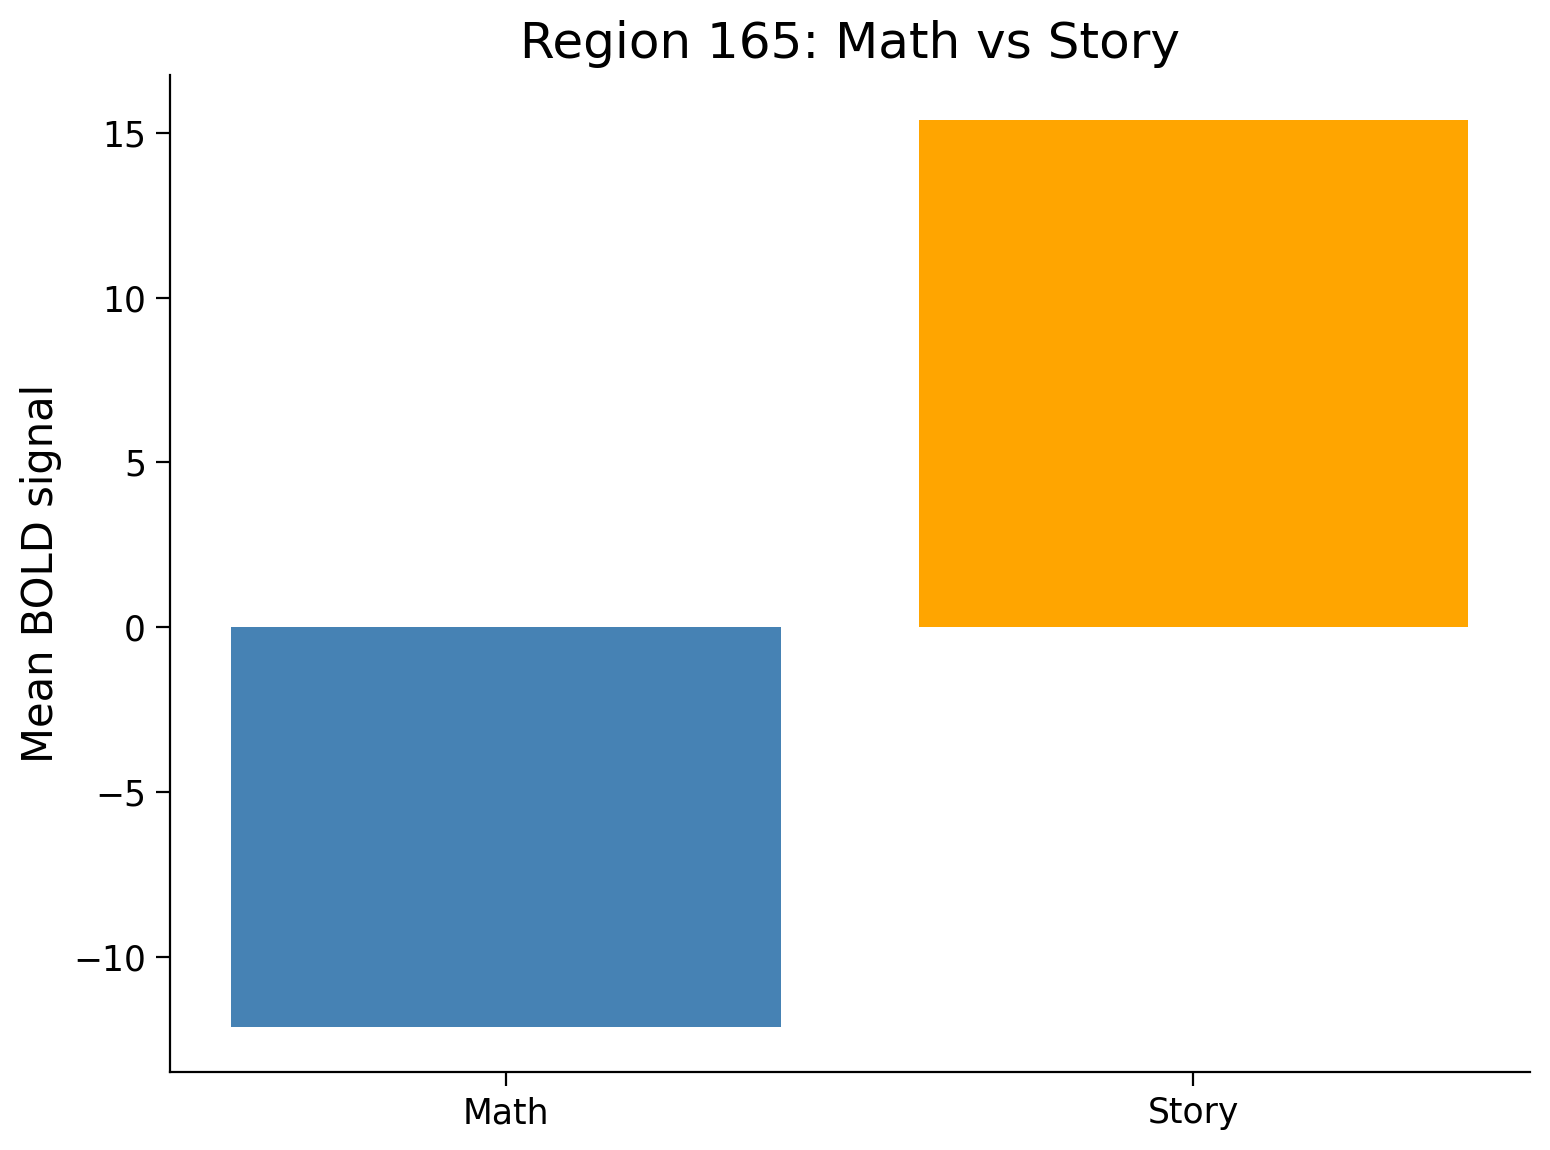

In [22]:
region_idx = 165 # this is R_pOFC
region_ts = data[region_idx]


def get_safe_indices(trials, max_len):
   flat = np.concatenate(trials)
   return flat[flat < max_len]


math_idxs = get_safe_indices(evs[0], len(region_ts))
story_idxs = get_safe_indices(evs[1], len(region_ts))


math_vals = np.mean(region_ts[math_idxs])
story_vals = np.mean(region_ts[story_idxs])


plt.bar(['Math', 'Story'], [math_vals, story_vals], color=['steelblue', 'orange'])
plt.ylabel('Mean BOLD signal')
plt.title(f'Region {region_idx}: Math vs Story')
plt.show()

Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:
    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=10000)
    # Get the accuracy for each test split using cross-validation
    accs = cross_val_score(model, X, y, cv=8)
    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())
  index= np.argmax(accuracies)
  C_max = C_values[index]
  model = LogisticRegression(penalty="l2", C=C_max, max_iter=10000)
  model.fit(X,y)
  return model, C_max


X = df_trials
y = df_meta["condition"].map({"math": 0, "story": 1}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
C_values = np.logspace(-4, 4, 9)

log_model, C_max = model_selection(X_train, y_train, C_values)

In [24]:
from sklearn.metrics import accuracy_score

y_pred = log_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

train_preds = log_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
print(train_acc)

Accuracy: 0.9981308411214953
0.9995327102803738


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1504
           1       1.00      1.00      1.00       636

    accuracy                           1.00      2140
   macro avg       1.00      1.00      1.00      2140
weighted avg       1.00      1.00      1.00      2140



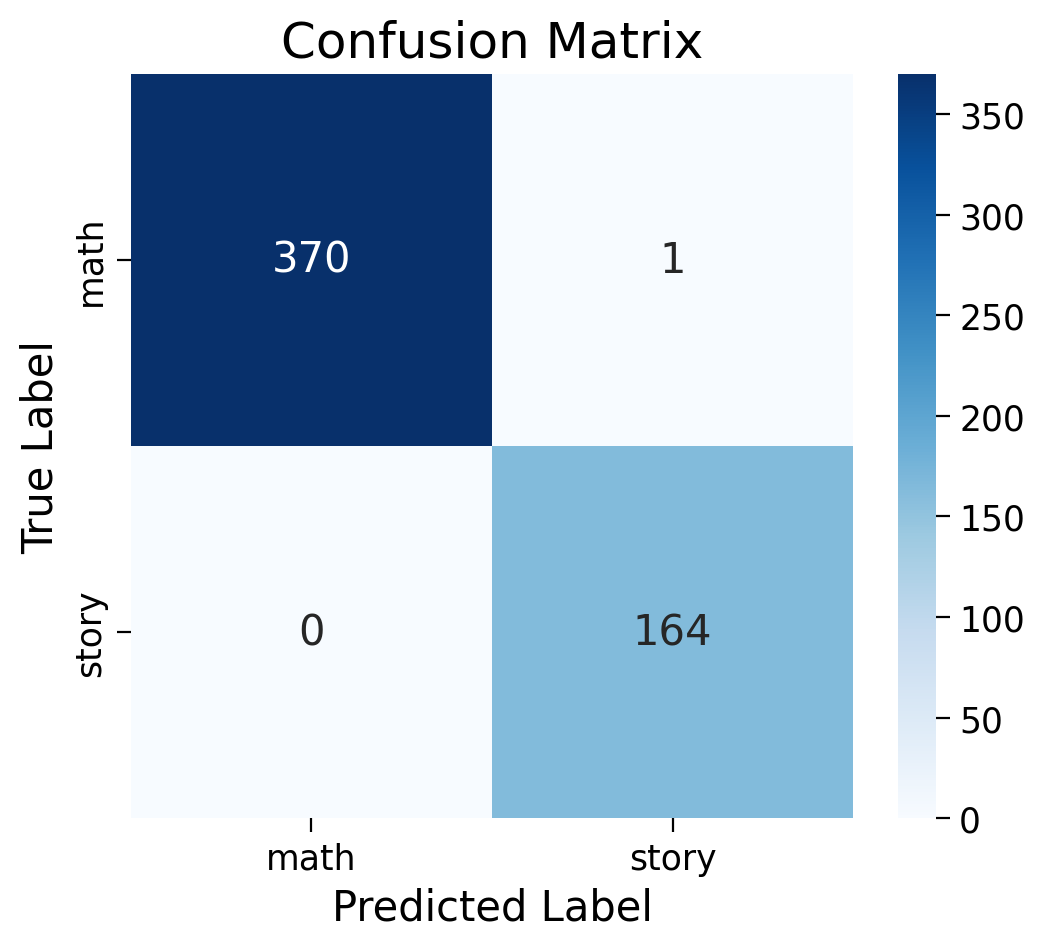

In [25]:
from sklearn.metrics import classification_report

cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['math', 'story'], yticklabels=['math', 'story'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

print(classification_report(y_train, train_preds))

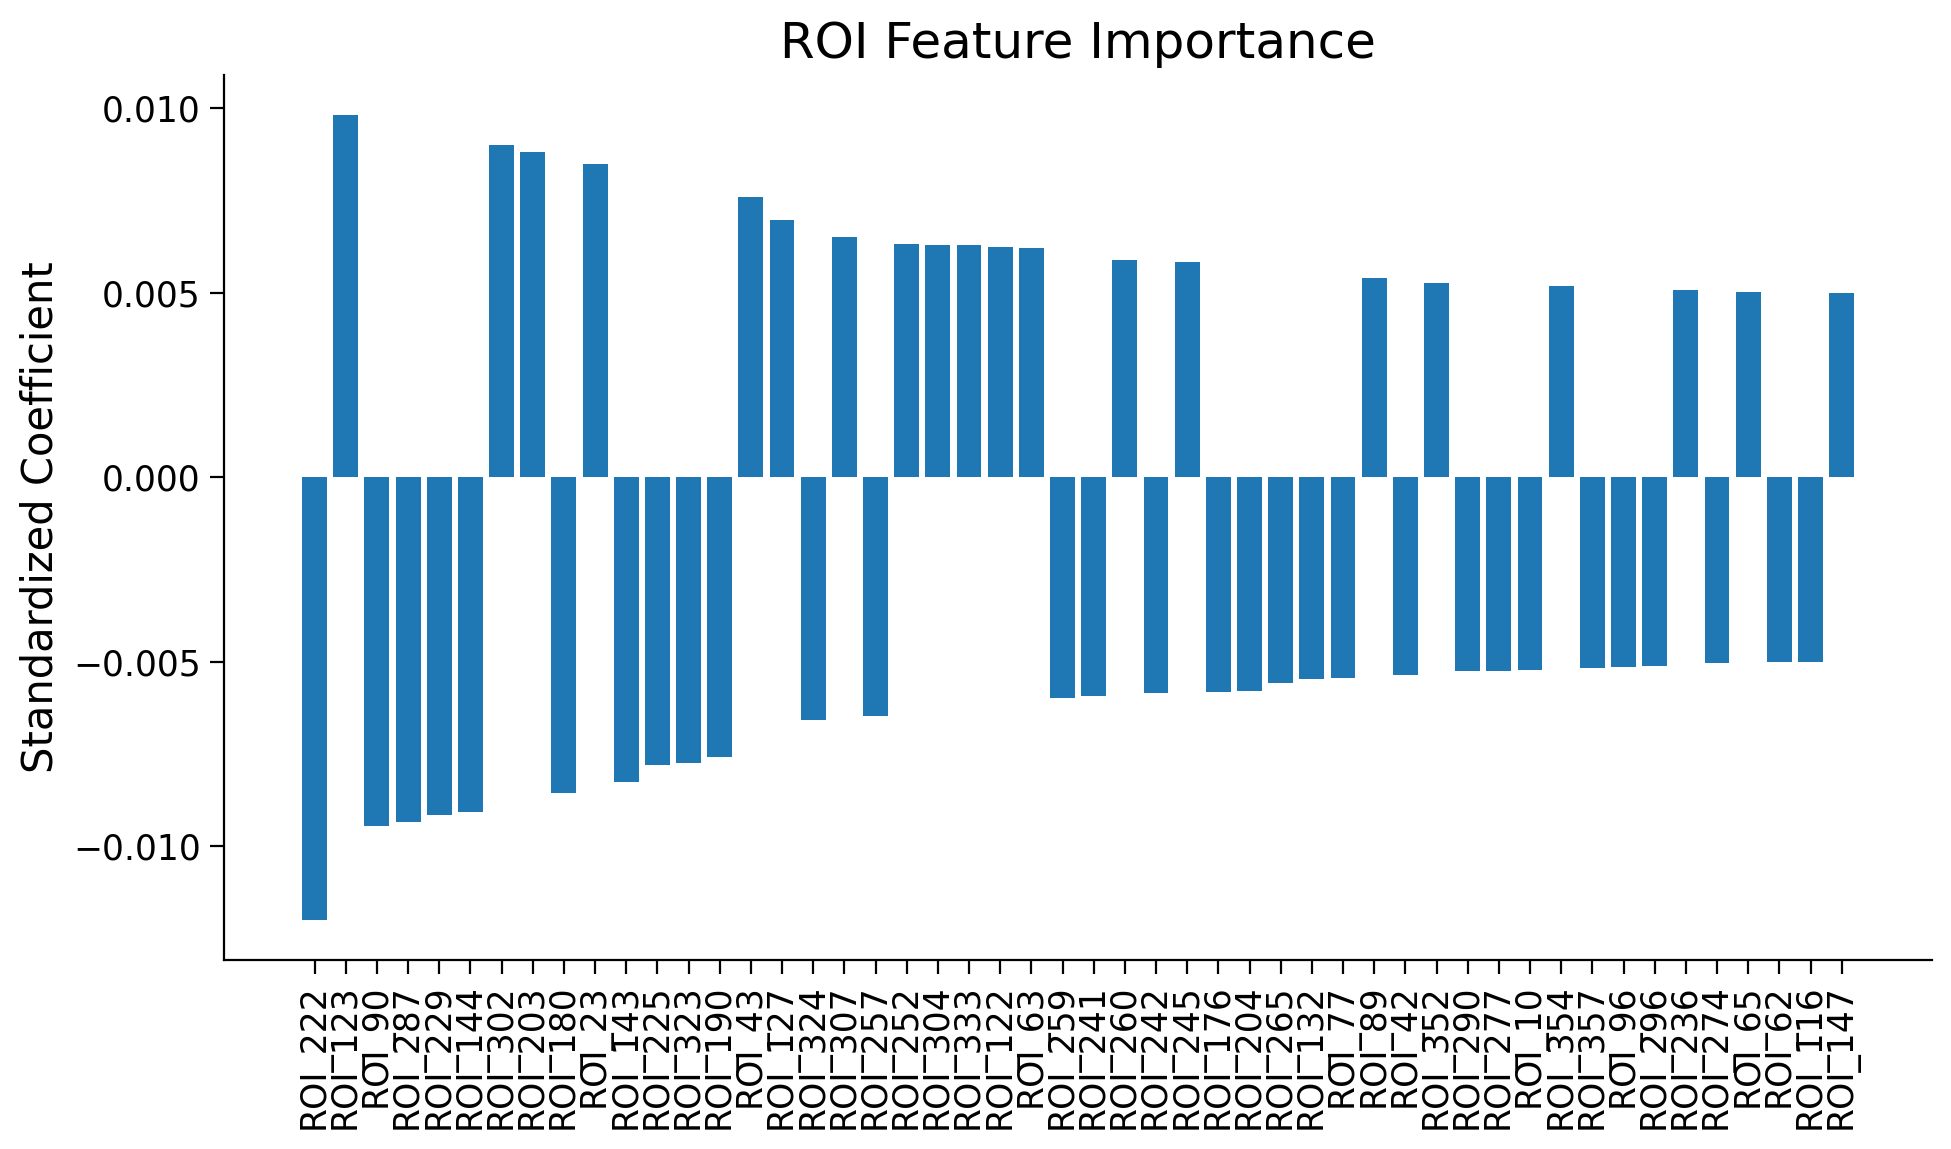

In [26]:
import matplotlib.pyplot as plt

coef = log_model.coef_.flatten()  # For binary classification
roi_names = list(df_trials.columns) # Replace with your actual list of ROI/feature names

# Sort features by importance
sorted_idx = np.argsort(np.abs(coef))[::-1]
sorted_coef = coef[sorted_idx]
sorted_labels = np.array(roi_names)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coef[:50])), sorted_coef[:50], tick_label=sorted_labels[:50])
plt.xticks(rotation=90)
plt.ylabel('Standardized Coefficient')
plt.title('ROI Feature Importance')
plt.tight_layout()
plt.show()

Use only 4 math trials

In [27]:
df_limited = (
    df_all
    .groupby(['subject', 'condition'], group_keys=False)
    .apply(lambda x: x.head(4))
    .reset_index(drop=True)
)

X = df_limited.iloc[:, 4:363]
y = df_limited['condition'].map({"math": 0, "story": 1}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
C_values = np.logspace(-4, 4, 9)

log_model, C_max = model_selection(X_train, y_train, C_values)


/tmp/ipython-input-27-2970505061.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(4))


Accuracy: 0.9875
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       310
           1       1.00      1.00      1.00       330

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



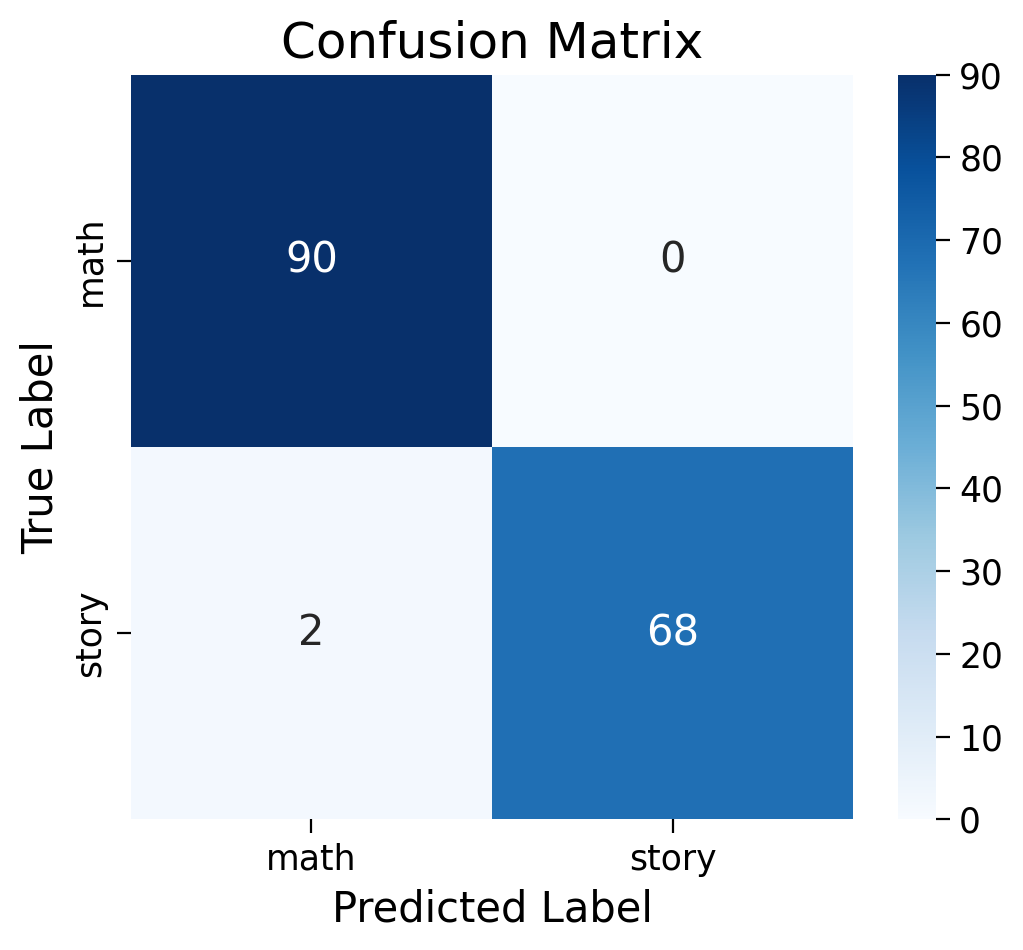

In [28]:
y_pred = log_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

train_preds = log_model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
print(train_acc)

cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['math', 'story'], yticklabels=['math', 'story'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

print(classification_report(y_train, train_preds))

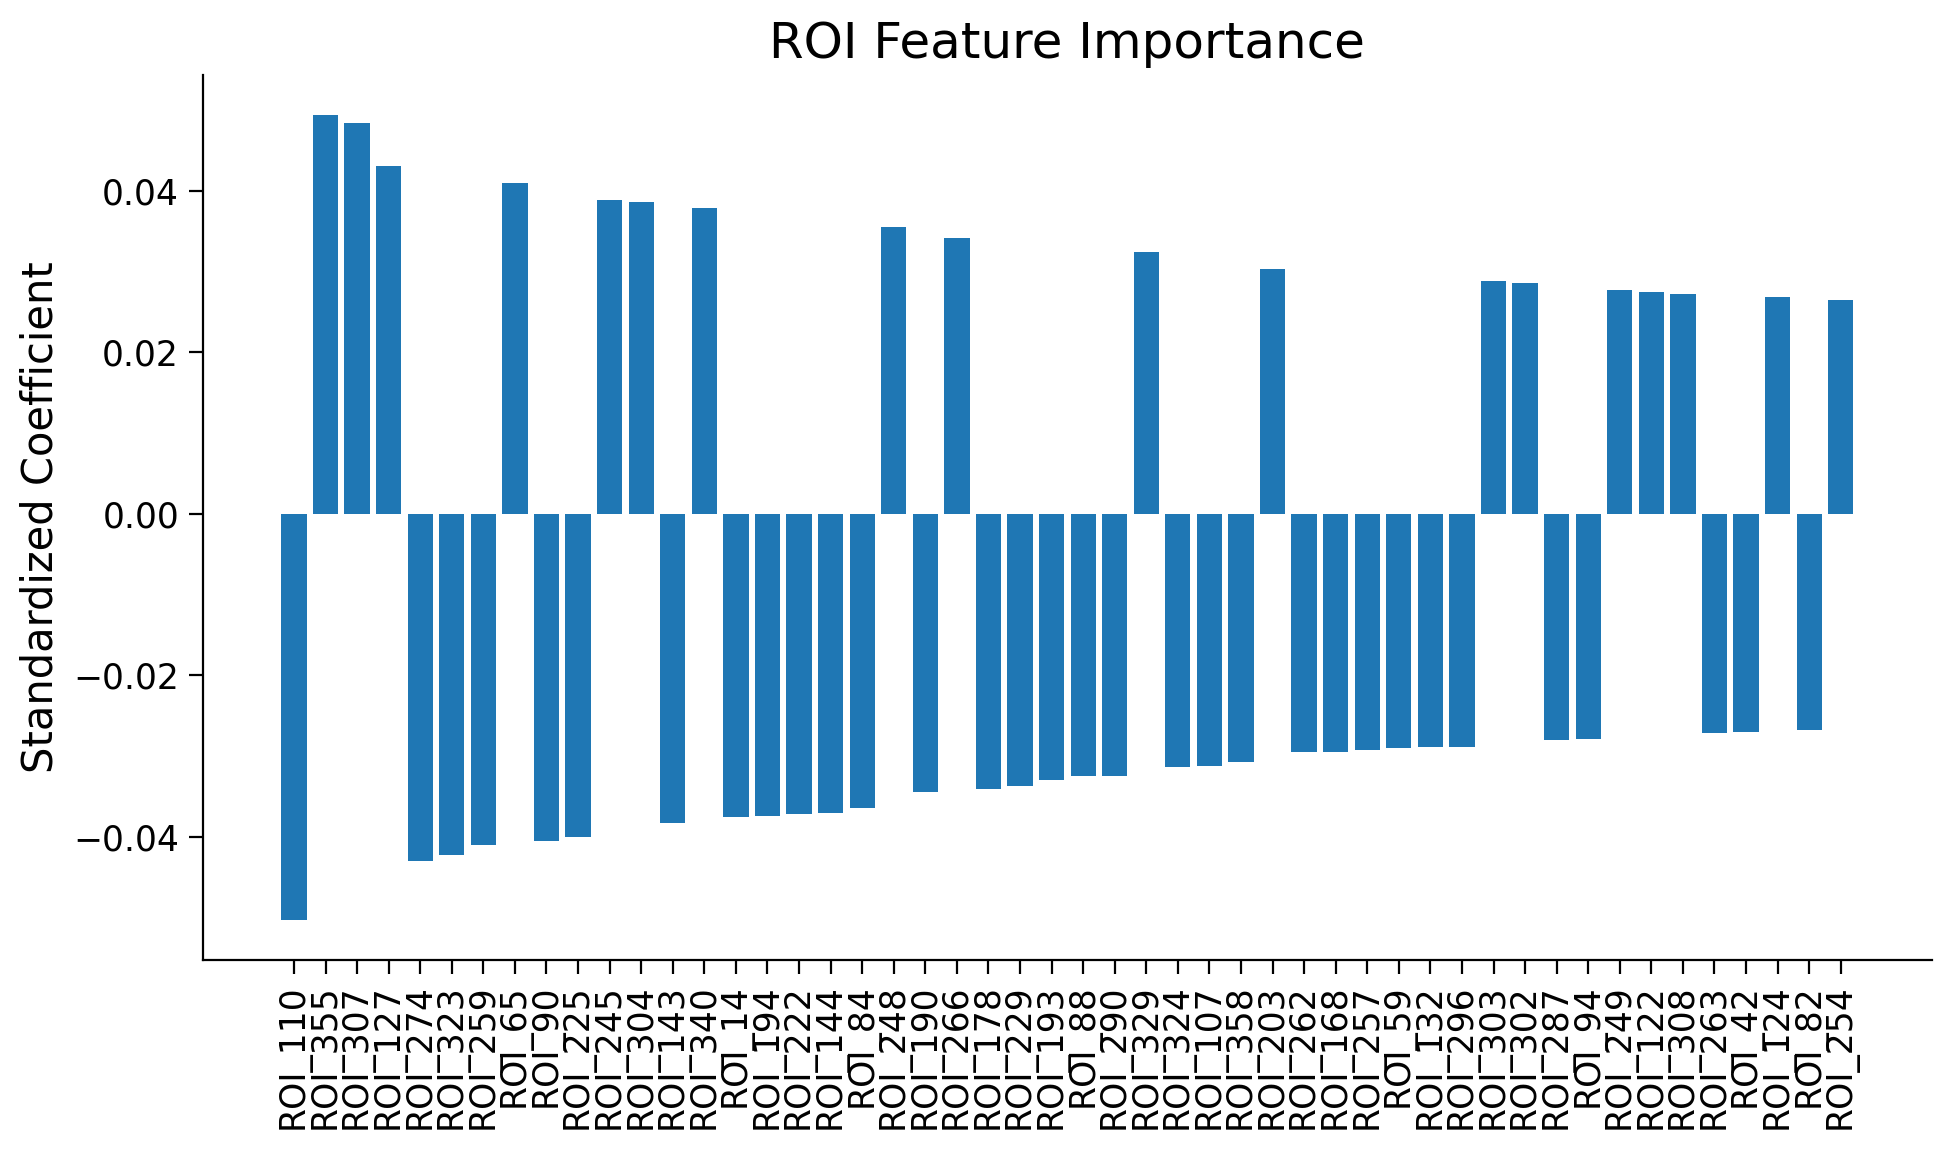

In [29]:
coef = log_model.coef_.flatten()  # For binary classification
roi_names = list(X.columns) # Replace with your actual list of ROI/feature names

# Sort features by importance
sorted_idx = np.argsort(np.abs(coef))[::-1]
sorted_coef = coef[sorted_idx]
sorted_labels = np.array(roi_names)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coef[:50])), sorted_coef[:50], tick_label=sorted_labels[:50])
plt.xticks(rotation=90)
plt.ylabel('Standardized Coefficient')
plt.title('ROI Feature Importance')
plt.tight_layout()
plt.show()

## Re-labeling

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
df = pd.read_excel('Glasser_2016_Table.xlsx', engine='openpyxl')
lat_list = df['Lateralization'].tolist()
area_list = df['Area\xa0Description'].tolist()
area_list = [s.replace('\n', ' ') for s in area_list]
full_roi_lables = [f"{lat} - {area}" for lat, area in zip(lat_list, area_list)]
print(full_roi_lables[:5])  # preview first 5 entries
# df_trials.columns = combined

In [ ]:
sorted_labels = np.array(full_roi_lables)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coef[:50])), sorted_coef[:50], tick_label=sorted_labels[:50])
plt.xticks(rotation=90)
plt.ylabel('Standardized Coefficient')
plt.title('ROI Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
print(sorted_labels[:10])

# ROI analysis